# import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.executable

'/home/lcances/.miniconda3/envs/dct/bin/python'

In [3]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NU M_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"
import time
import pprint
from typing import Union

import numpy
from torchsummary import summary

import torch
from torch.cuda import empty_cache
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.cuda.amp import autocast
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

In [4]:
from SSL.util.loaders import load_dataset, load_optimizer, load_callbacks, load_preprocesser
from SSL.util.model_loader import load_model
from SSL.util.checkpoint import CheckPoint, mSummaryWriter
from SSL.util.utils import reset_seed, get_datetime, track_maximum, DotDict
from SSL.ramps import Warmup, sigmoid_rampup
from SSL.losses import JensenShanon

from metric_utils.metrics import CategoricalAccuracy, FScore, ContinueAverage

In [5]:
import augmentation_utils.spec_augmentations as sa

In [14]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--from_config", default="", type=str)
parser.add_argument("-d", "--dataset_root", default="../datasets", type=str)
parser.add_argument("-D", "--dataset", default="esc10", type=str)

group_t = parser.add_argument_group("Commun parameters")
group_t.add_argument("-m", "--model", default="wideresnet28_2", type=str)
group_t.add_argument("--supervised_ratio", default=0.1, type=float)
group_t.add_argument("--batch_size", default=64, type=int)
group_t.add_argument("--nb_epoch", default=150, type=int)
group_t.add_argument("--learning_rate", default=0.003, type=float)
group_t.add_argument("--resume", action="store_true", default=False)
group_t.add_argument("--seed", default=1234, type=int)

group_m = parser.add_argument_group("Model parameters")
group_m.add_argument("--num_classes", default=35, type=int)

group_u = parser.add_argument_group("Datasets parameters")
group_u.add_argument("-t", "--train_folds", nargs="+", default=[1, 2, 3, 4], type=int)
group_u.add_argument("-v", "--val_folds", nargs="+", default=[5], type=int)

group_s = parser.add_argument_group("Student teacher parameters")
group_s.add_argument("--ema_alpha", default=0.999, type=float)
group_s.add_argument("--warmup_length", default=50, type=int)
group_s.add_argument("--lambda_cost_max", default=1, type=float)
group_s.add_argument("--teacher_perturb_fn", default="identity", type=str)
group_s.add_argument("--ccost_softmax", action="store_false", default=True)
group_s.add_argument("--ccost_method", type=str, default="mse")

group_l = parser.add_argument_group("Logs")
group_l.add_argument("--checkpoint_root", default="../model_save/", type=str)
group_l.add_argument("--tensorboard_root", default="../tensorboard/", type=str)
group_l.add_argument("--checkpoint_path", default="mean-teacher", type=str)
group_l.add_argument("--tensorboard_path", default="mean-teacher", type=str)
group_l.add_argument("--tensorboard_sufix", default="", type=str)

args=parser.parse_args("")

tensorboard_path = os.path.join(args.tensorboard_root, args.dataset, args.tensorboard_path)
checkpoint_path = os.path.join(args.checkpoint_root, args.dataset, args.checkpoint_path)

## Basic verification

In [15]:
available_datasets = ["esc10", "ubs8k", "speechcommand"]
available_models = ["cnn03", "wideresnet28_2", "wideresnet28_4", "wideresnet28_8"]
available_ccost_method = ["mse", "js"]

assert args.dataset.lower() in available_datasets
assert args.model.lower() in available_models
assert args.ccost_method.lower() in available_ccost_method

In [16]:
pprint.pprint(vars(args))

{'batch_size': 64,
 'ccost_method': 'mse',
 'ccost_softmax': True,
 'checkpoint_path': 'mean-teacher',
 'checkpoint_root': '../model_save/',
 'dataset': 'esc10',
 'dataset_root': '../datasets',
 'ema_alpha': 0.999,
 'from_config': '',
 'lambda_cost_max': 1,
 'learning_rate': 0.003,
 'model': 'wideresnet28_2',
 'nb_epoch': 150,
 'num_classes': 35,
 'resume': False,
 'seed': 1234,
 'supervised_ratio': 0.1,
 'teacher_perturb_fn': 'identity',
 'tensorboard_path': 'mean-teacher',
 'tensorboard_root': '../tensorboard/',
 'tensorboard_sufix': '',
 'train_folds': [1, 2, 3, 4],
 'val_folds': [5],
 'warmup_length': 50}


# initialisation

In [17]:
reset_seed(args.seed)

In [18]:
from SSL.trainers.trainers import Trainer

class MeanTeacherTrainer(Trainer):
    def __init__(self, model: str, dataset: str,
                 ema_alpha: float = 0.999,
                 teacher_noise_db: int = 0,
                 warmup_length: int = 50,
                 lambda_ccost_max: float = 1,
                 use_softmax: bool = False,
                 ccost_method: str = "mse"):

        super().__init__(model, "mean-teacher", dataset)

        self.ema_alpha = ema_alpha
        self.teacher_noise_db = teacher_noise_db
        self.warmup_length = warmup_length
        self.lambda_ccost_max = lambda_ccost_max
        self.use_softmax = use_softmax
        self.ccost_method = ccost_method

        self.extra_hparams = dict(
            ema_alpha=self.ema_alpha,
            teacher_noise_db=self.teacher_noise_db,
            warmup_length=self.warmup_length,
            lambda_ccost_max=self.lambda_ccost_max,
            use_softmax=self.use_softmax,
            ccost_method=self.use_softmax,
        )

        self.softmax_fn = lambda x: x
        if self.use_softmax:
            self.softmax_fn = nn.Softmax(dim=1)

trainer = MeanTeacherTrainer(args.model, args.dataset)

# Prepare the dataset

In [19]:
trainer.load_transforms()

Load the transformation


In [20]:
from types import MethodType

def _get_input_shape(self):
    return tuple(self.train_loader._iterables[0].dataset[0][0].shape)

trainer._get_input_shape = MethodType(_get_input_shape, trainer)

In [21]:
parameters = dict(
    dataset=args.dataset,

    dataset_root = args.dataset_root,
    supervised_ratio = args.supervised_ratio,
    batch_size = args.batch_size,
    nb_epoch=args.nb_epoch,
    train_folds = args.train_folds,
    val_folds = args.val_folds,
    
    num_workers=0,
    pin_memory=True,

    verbose = 2,
)

trainer.load_dataset(parameters)

Load the dataset
Dataset already downloaded and verified.
Dataset already downloaded and verified.
s_batch_size:  6
u_batch_size:  58


# Spec augmentation

In [29]:
D = lambda idx: trainer.train_loader._iterables[0].dataset[idx][0]

In [110]:
import matplotlib.pyplot as plt 

original = D(0)

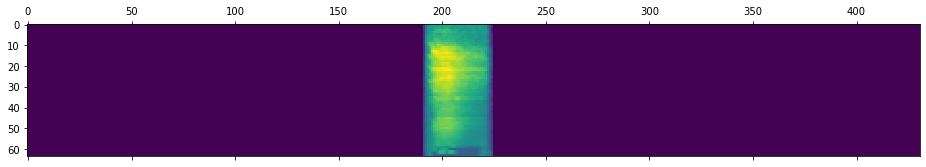

In [111]:
plt.matshow(original)

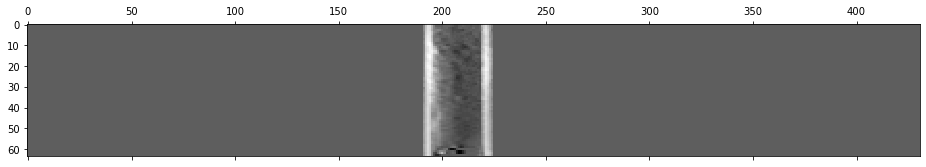

In [162]:
aug = sa.FractalTimeDropout(
    ratio=1.0,
    min_chunk_size=20,
    min_chunk=1,
    max_chunk=1,
    void=True,
    cut=True
)
plt.matshow(aug(original) - original, cmap="Greys")

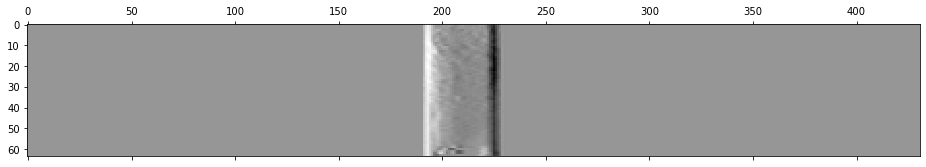

In [163]:
aug = sa.FractalTimeStretch(
    ratio=1.0,
    min_chunk_size=20,
)
plt.matshow(aug(original) - original, cmap="Greys")

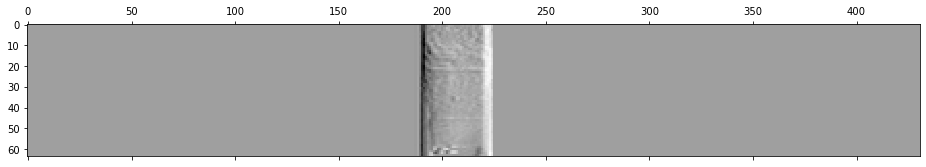

In [173]:
aug = sa.FractalStretch(1.0, freq_min_chunk_size=4, freq_max_chunk_size=8, time_min_chunk_size=16, time_max_chunk_size=48)
plt.matshow(aug(original) - original, cmap="Greys")

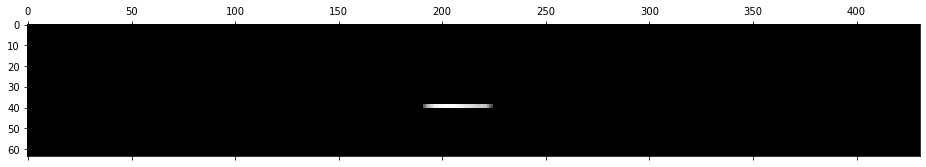

In [161]:
aug = sa.FractalDropout(1.0, freq_min_chunk_size=1, freq_max_chunk_size=3, freq_max_chunk=1, time_max_chunk=1)
plt.matshow(aug(original) - original, cmap="Greys")

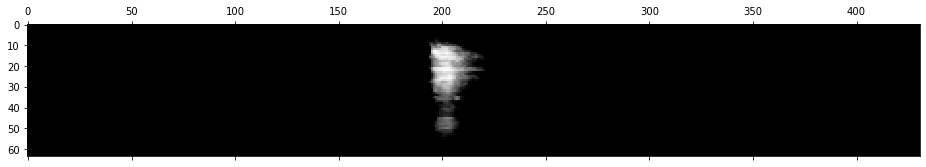

In [159]:
aug = sa.UniformSignNoise(1.0, 0.1, mini=-100, maxi=0)
plt.matshow(aug(original) - original, cmap="Greys")

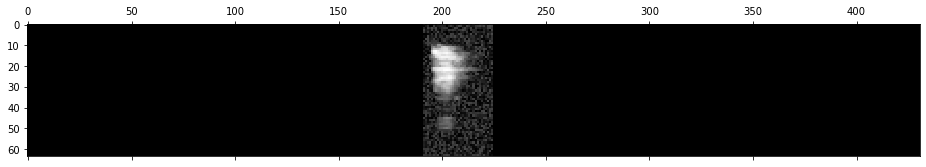

In [164]:
aug = sa.Noise(1.0, 10, mini=-100, maxi=0)
plt.matshow(aug(original) - original, cmap="Greys")